In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [2]:
df = pd.read_csv('./data/cervical-cancer_csv.csv')

See how data looks like

In [3]:
df.shape

(835, 36)

In [4]:
df.isnull().sum()

Age                                     0
Number of sexual partners              25
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               103
Hormonal Contraceptives (years)       103
IUD                                   112
IUD (years)                           112
STDs                                  100
STDs (number)                         100
STDs:condylomatosis                   100
STDs:cervical condylomatosis          100
STDs:vaginal condylomatosis           100
STDs:vulvo-perineal condylomatosis    100
STDs:syphilis                         100
STDs:pelvic inflammatory disease      100
STDs:genital herpes                   100
STDs:molluscum contagiosum            100
STDs:AIDS                             100
STDs:HIV                              100
STDs:Hepatitis B                  

Get the columns with less than 150 values to fill the NaN with zeros

In [5]:
a = dict(df.isnull().sum()>150)

In [6]:
columns_keep = [key for key, value in a.items() if value == False]

Filtrar el df

In [7]:
df_f = df[columns_keep]

Fill NaN values with zero. It is likely that NaN values exits because the doctors were not able to register any information

In [8]:
df_f = df_f.fillna(0)

Verify if the classification is balanced or not

<AxesSubplot: xlabel='Biopsy', ylabel='count'>

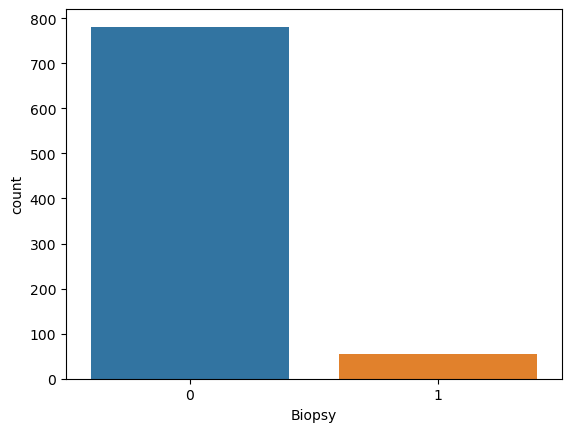

In [9]:
sns.countplot(data = df_f, x = 'Biopsy', )

Thus, it means that the dataset is imbalanced.

Select important variables for the classification model

In [10]:
import phik

In [11]:
matrix_corr = df_f.phik_matrix()

interval columns not set, guessing: ['Age', 'Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis', 'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease', 'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy']


c:\Users\LP00035\anaconda3\envs\knime\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable STDs:cervical condylomatosis for analysis 1. Dropping this column
  warnings.warn(
c:\Users\LP00035\anaconda3\envs\knime\lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable STDs:AIDS for analysis 1. Dropping this column
  warnings.warn(


In [12]:
useful_var = list(matrix_corr.query('Biopsy > 0.1').index)

Filter columns which has an important correlation

In [13]:
df_u = df_f[useful_var]

Split data into train and test

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
train, test = train_test_split(df_u, test_size = 0.3, random_state = 99)

# Machine Learning Modeling

In [16]:
from pycaret.classification import *

Normalize and standarize the data

In [17]:
data = setup(data = train, target = 'Biopsy', session_id = 99, normalize = True, normalize_method = 'minmax', 
             transformation = True, experiment_name = 'cancer_cervical', log_data = True, fix_imbalance = True)

,Description,Value
0,Session id,99
1,Target,Biopsy
2,Target type,Binary
3,Original data shape,"(584, 16)"
4,Transformed data shape,"(938, 16)"
5,Transformed train set shape,"(762, 16)"
6,Transformed test set shape,"(176, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


Train different models and select the models

In [18]:
results =  compare_models(verbose = True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:02:25
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9655,0.0000,0.9333,0.7350,0.7974,0.7809,0.8010,0.9450
lda,Linear Discriminant Analysis,0.9631,0.9504,0.9333,0.7100,0.7831,0.7653,0.7865,0.7660
knn,K Neighbors Classifier,0.9607,0.9511,0.9000,0.7345,0.7612,0.7426,0.7726,0.9440
et,Extra Trees Classifier,0.9583,0.9601,0.7333,0.6917,0.6807,0.6634,0.6808,0.8740
lr,Logistic Regression,0.9582,0.9715,0.9333,0.6779,0.7574,0.7376,0.7639,1.5300
rf,Random Forest Classifier,0.9558,0.9627,0.7333,0.8000,0.6950,0.6746,0.7117,1.1630
svm,SVM - Linear Kernel,0.9557,0.0000,0.9000,0.6600,0.7355,0.7140,0.7383,0.9670
lightgbm,Light Gradient Boosting Machine,0.9533,0.9399,0.6500,0.7800,0.6569,0.6348,0.6644,0.9230
ada,Ada Boost Classifier,0.9509,0.8237,0.7167,0.6783,0.6810,0.6561,0.6645,0.8360
dt,Decision Tree Classifier,0.9485,0.7882,0.6000,0.7483,0.6024,0.5780,0.6142,0.8840


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [19]:
best_model = automl(optimize = 'AUC')
tunned_model = tune_model(estimator = best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9512,1.0000,1.0000,0.6000,0.7500,0.7248,0.7539
2,0.9268,0.9386,1.0000,0.5000,0.6667,0.6306,0.6786
3,0.9512,0.9737,1.0000,0.6000,0.7500,0.7248,0.7539
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9268,0.8772,0.3333,0.5000,0.4000,0.3627,0.3712
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9756,1.0000,1.0000,0.6667,0.8000,0.7876,0.8060
8,0.9500,0.9737,1.0000,0.5000,0.6667,0.6429,0.6882


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Select the best model

In [20]:
final_model = finalize_model(estimator = tunned_model)

# Save the scores over the test dataset

Test the model and see the results

In [21]:
scores = predict_model(final_model, test)
scores = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9522,0.9655,0.8667,0.5652,0.6842,0.6596,0.6773


In [22]:
diccionario = scores.to_dict()

In [23]:
import json

In [24]:
# Guardar el diccionario como un archivo JSON
with open("./metrics/metrics_model.json", "w") as json_file:
    json.dump(diccionario, json_file)

# Save the model

In [25]:
import joblib

In [26]:
joblib.dump(final_model, './models/trained_model.joblib')

['./models/trained_model.joblib']

# Save hyperparameters 

The hyperparameters are going to be saved in dagshub

In [29]:
import dagshub

In [34]:
with dagshub.dagshub_logger() as logger:
    # save hyperparameters of the model
    logger.log_hyperparams({'model': final_model.get_params()})
    # save the metrics of the model
    logger.log_metrics({'Evaluation metrics': scores.to_dict()})